# 1 -Perkenalan

Nama: Ikhbar Firman Hanafi

Batch: 14

Phase: 1

## Data set
Dataset yang dignakan disini adalah data pasien dengan berbagai record medis yang diambil dari Google BigQuery:
- Project ID : ftds-hacktiv8-project
- Dataset Name : phase1_ftds_014
- Table Name : heart-failure

Adapun proses query data sebagai berikut:

    select *

    from `ftds-hacktiv8-project.phase1_ftds_014.heart-failure`;

## Objective

Memprediksi Death event pasien berdasarkan berbagai data medis.

## Detail deskripsi kolom data

<div><center><img src="https://camo.githubusercontent.com/74367182fd06603b4568da9dba93c9483897646c50c55aa6392a68e99996d086/68747470733a2f2f692e6962622e636f2f594247774d586d2f50312d47332d446174617365742d496e666f726d6174696f6e2e706e67" width="700"></center></div>

# 2 - Import Libraries

Import libraries yang diperlukan

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve

# 3 - Data Loading

Load dataset menjadi suatu DataFrame

In [214]:
data = pd.read_csv('h8dsft_P1G3_ikhbar_firman.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,42.0,1,250,1,15,0,213000.0,1.3,136,0,0,65,1
1,46.0,0,168,1,17,1,271000.0,2.1,124,0,0,100,1
2,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
3,53.0,1,91,0,20,1,418000.0,1.4,139,0,0,43,1
4,50.0,1,582,1,20,1,279000.0,1.0,134,0,0,186,0


In [215]:
data.tail()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
294,63.0,1,122,1,60,0,267000.00,1.2,145,1,0,147,0
295,45.0,0,308,1,60,1,377000.00,1.0,136,1,0,186,0
296,70.0,0,97,0,60,1,220000.00,0.9,138,1,0,186,0
297,53.0,1,446,0,60,1,263358.03,1.0,139,1,0,215,0
298,50.0,0,582,0,62,1,147000.00,0.8,140,1,1,192,0


Kita akan coba membuat bakcup dataset untuk berjaga-jaga apabila seandainya nanti terjadi perubahan data yang tidak diinginkan.

In [216]:
# Duplicate data set
data_copy = data.copy()

In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Dari sejumlah 299 data, kita dapat melihat tidak terdeteksi missing value (NaN) pada semua features. Features value data berupa numerical dengan tipe int64 (integer) dan float64(real numbers). Diantara features tersebut ada yang termasuk categorical (dengan value integer) yaitu anaemia, diabetes, high_blood_pressure, sex dan smoking. Target ouput DEATH_EVENT disini juga termasuk kategori, dimana value 1 menandakan pasien akan meninggal dan value 0 menandakan tidak meninggal dalam suatu periode.

Kita akan coba melihat unique value apa saja pada feature categorical.

In [218]:
cat_cols = ['anaemia','diabetes','high_blood_pressure','sex','smoking']
for i in cat_cols:
    print(f'{i}: {data[i].unique()}')

anaemia: [1 0]
diabetes: [1 0]
high_blood_pressure: [0 1]
sex: [0 1]
smoking: [0 1]


Value pada tiap categorical feature sudah sesuai dengan deskripsi dataset, yakni boolean 0 dan 1, kecuali pada sex dimana 0 dan 1 menandakan male atau female (tidak dijelaskan apakah value 0 atau 1 itu male atau female pada deskripsi data).

Untuk mempermudah proses kedepannya, kita akan mengganti penulisan nama target output DEATH_EVENT dengan lowercase death.

In [219]:
data.rename(columns={'DEATH_EVENT':'death'},inplace=True)

In [220]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Berdasarkan penjabaran di atas:
- Rentang usia pasien di dataset dari 40 hingga 95. Tidak terlihat suatu keanehan value disini, seperti negative value atau value yang sangat besar seperti 200 yang kurang masuk akal.
- Pada categorical features seperti anaemia, diabetes, high_blood_pressure,sex, smoking dan target death memiliki value minimum 0 dan maksimum 1 sesuai dengan deskripsi data.
- Feature ejection_fraction dengan minimum 14 dan maksimum 80 nampak sudah sesuai, mengingat value disini merupakan persentase jumlah darah yang meninggalkan jantung dalam tiap kontraksi.
 - Feature lain seperti platelets, serum_creantinine, serum_sodium dan time (periods) tidak ditemukan value yang aneh.

Kita akan explore lebih lanjut value dataset pada proses berikutnya yaitu Exploratory Data Analysis (EDA).

# 4 - Exploratory Data Analysis (EDA)

Pertama kita kan lihat bagaimana proporsi value pada terget output death.

0    203
1     96
Name: death, dtype: int64


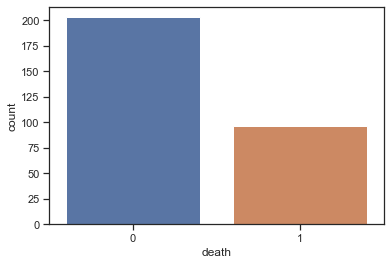

In [221]:
#Barplot target death
sns.countplot(x='death',data=data)
print(data['death'].value_counts())

Berdasarkan bar chart di atas kita bisa melihat bahwa dataset dengan value target 1 jauh lebih sedikit dibanding value 0. Dimana terdapat sejumlah 203 target value 0 dan 96 target value 1. Oleh karena itu dataset ini tergolong **imbalanced data**.

Berikutnya kita coba cek distribusi feature 'age' terhadap masing-masing value target 'death'.

In [222]:
mean_age_death = data[['age','death']].groupby('death').mean()
mean_age_death

,age
death,
0,58.761906
1,65.215281


Text(0.5, 1.0, 'Age and Death = 0')

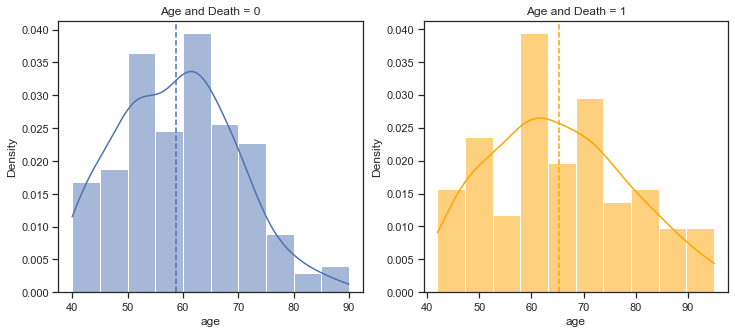

In [223]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
sns.histplot(x = 'age',data=data[data['death'] == 1], bins=10, stat='density',kde=True, color='orange')
plt.axvline(mean_age_death.age.iloc[1], linestyle='dashed',color = 'orange')
plt.title('Age and Death = 1')

plt.subplot(1,2,1)
sns.histplot(x = 'age',data=data[data['death'] == 0], bins=10, stat='density',kde=True)
plt.axvline(mean_age_death.age.iloc[0], linestyle='dashed')
plt.title('Age and Death = 0')


Berdasarkan kedua grafik tersebut, terlihat bahwa proporsi umur pada pasien yang meninggal di umur tua (lebih besar 80) lebih besar dibanding proporsi umur pada pasien tua yang tidak meninggal. Untuk umur 80 kebawah tidak begitu nampak perbedaan proporsi umur pasien yang meninggal maupun yang tidak, atau dengan kata lain distribusi kedua grafik tersebut cukup mirip untuk umur di bawah 80. Berdasarkan hal tersebut faktor usia cukup berhubungan dengan target status kematian pasien.

Berikutnya kita akan meninjau value feature anemia, age berdasarkan target death.

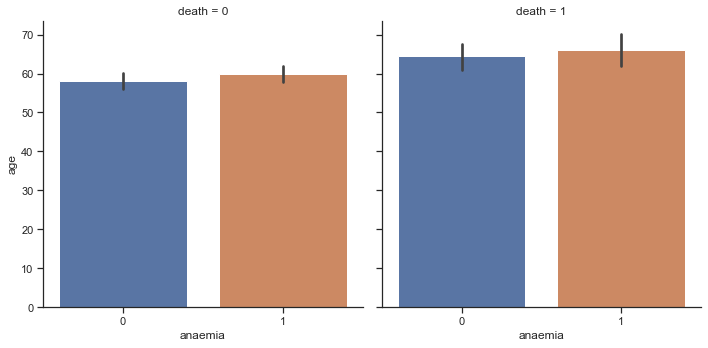

In [224]:
sns.catplot(x="anaemia", y='age', col="death",
                data=data, kind="bar")

Berdasarkan gambar di atas kita dapat melihat bahwa mean age pasien yang mengalami anemia maupun yang tidak adalah tidak begitu berbeda yakni sekitar 57 pada pasien yang masih hidup. Hal yang serupa juga pada pasien yang telah meninggal namuan dengan mean age sekitar 60. Berdasarkan hal ini nampak anaemia tidak terlihat berpengaruh pada meninggal atau tidaknya pasien.

Selanjutnya kita akan meninjau value diabetes berdasarkan status kematiannya.

Text(0.5, 1.0, 'Death = 1')

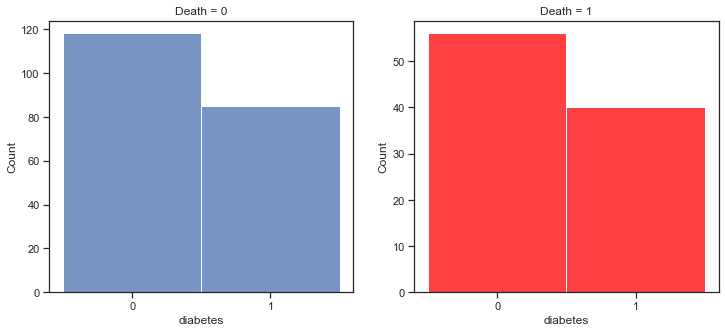

In [225]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(x = 'diabetes', data=data[data['death'] == 0], discrete=True,)
plt.xticks([0,1])
plt.title('Death = 0')

plt.subplot(1,2,2)
sns.histplot(x = 'diabetes', data=data[data['death'] == 1], discrete=True,color='red')
plt.xticks([0,1])
plt.title('Death = 1')

Dari gambar di atas, perbandingan jumlah pasien diabetes dan yang tidak diabetes pada pasien yang meninggal hampir sama dengan perbandingan pada pasien yang masih hidup. Dari sini nampaknya diabetes terlihat tidak begitu mempengaruhi status kematian pasien.

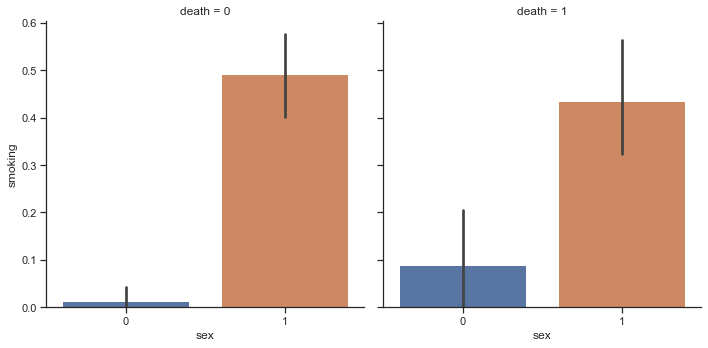

In [226]:
sns.catplot(x="sex", y='smoking', col="death",
                data=data, kind="bar")

Berdasarkan gambar di atas, value sex 0 memiliki proporsi jauh lebih kecil dibanding value sex 1. Diduga value sex 0 menandakan female, dan value sex 1 adalah male, berdasarkan mayoritas prokok adalah male. Baik sex dan status smoking nampak tidak begitu memperlihatkan perbedaan yang signifikan terhadap status kematian pasien.

Berikutnya kita akan coba melihat adakah perbedaan value time terhadap status kematian.

<AxesSubplot:xlabel='time', ylabel='Count'>

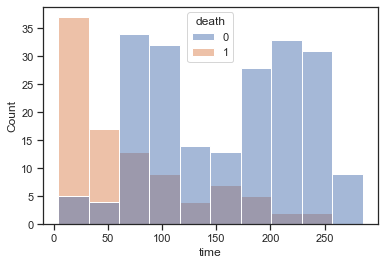

In [227]:
sns.histplot(x='time', hue='death',data=data)

Mengingat jumlah status kematian death = 0 lebih banyak daripada death = 1, histogram death = 0 jelas memiliki frekuensi leih besar. Sehingga kita tidak dapat begitu melihat perbedaan time terhadap status kematian. Kita akan coba melihat berdasarkan density time tiap status kematian.

Text(0.5, 1.0, 'Time and Death = 0')

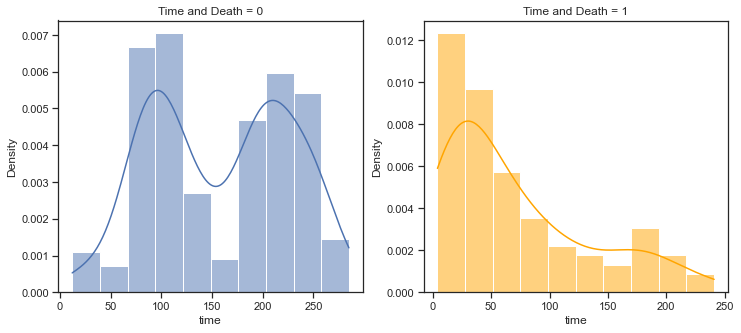

In [228]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
sns.histplot(x = 'time',data=data[data['death'] == 1], bins=10, stat='density',kde=True, color='orange')
plt.title('Time and Death = 1')

plt.subplot(1,2,1)
sns.histplot(x = 'time',data=data[data['death'] == 0], bins=10, stat='density',kde=True)
plt.title('Time and Death = 0')


Dari sini kita lebih jelas melihat bahwa untuk semakin besar time period akan semakin kecil proporsi pasien yang meninggal. Nampak feature time period ini cukup memiliki hubungan dengan target status kematian.

In [229]:
num_cols = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']

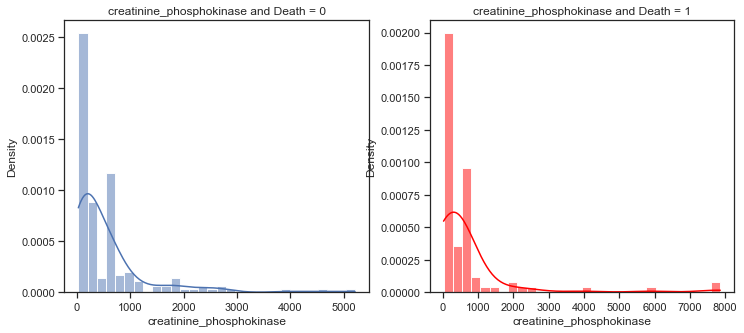

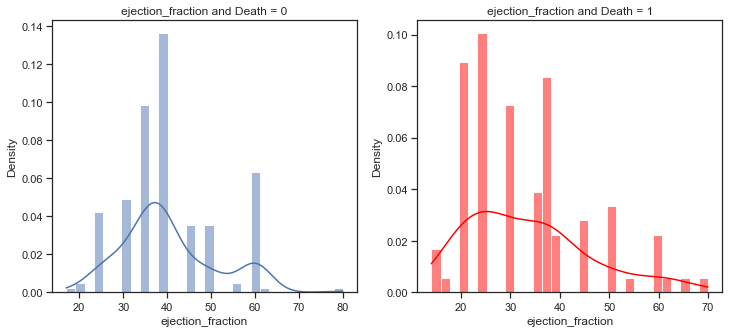

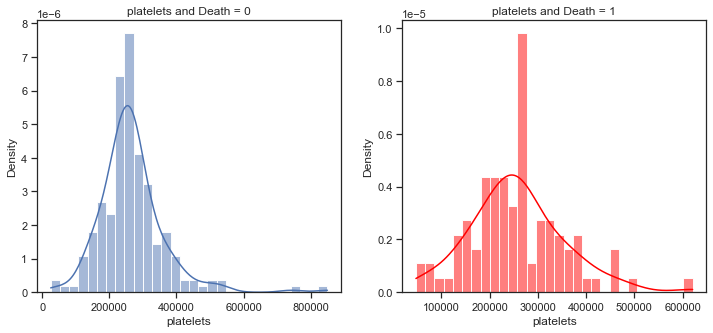

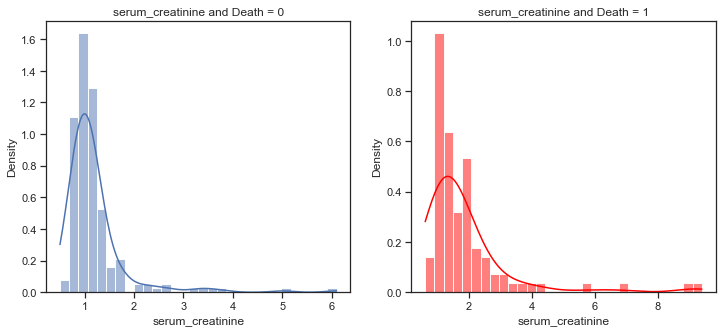

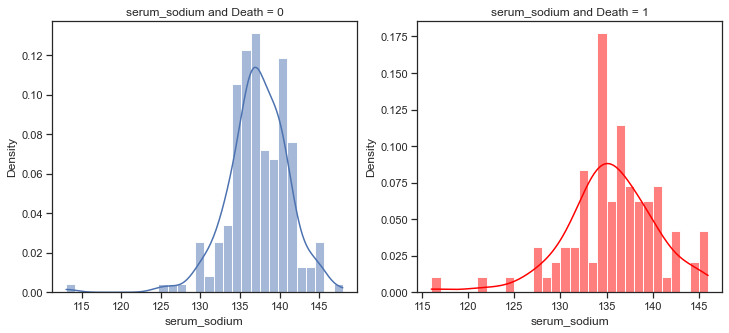

In [230]:
for col in num_cols[1:-1]:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(x = col,data=data[data['death'] == 0],bins=30 ,stat='density',kde=True)
    plt.title(f'{col} and Death = 0')

    plt.subplot(1,2,2)
    sns.histplot(x = col,data=data[data['death'] == 1], bins=30,kde=True, stat='density',color='red')
    plt.title(f'{col} and Death = 1')
    plt.show()

Dari gambar di atas, terdapat beberapa feature yang terlihat ada perbedaan value feature terhadap status kematian.
- Pada feature serum_creatinine sebagian besar proporsi jumlah pasien meninggal pada value dibawah 3. Dan terlihat pola semakin besar value serum_creatinine semakin mengecil proporsi jumlah pasien yang meninggal. Terlihat terdapat value di atas 6 pada pasien yang meninggal, berbeda dengan data pasien yang masih hidup dimana tidak terdapat value serum_creatinine di atas 6. Selain itu proporsi value creantinine antara 2 hingga 4 pada pasien yang meninggal lebih besar dibanding proporsi value tersebut pada pasien yang masih hidup.
- Pada feature ejection_fraction terlihat proporsi terbesar jumlah pasien yang meninggal pada value sekitar 20. Hal tersebut sangat berbeda pada pasien yang masih hidup, dimana pada value sekitar 20 proporsi ejection_fraction sangat kecil.

Selanjutnya kita akan coba melihat nilai korelasi (person correlation) antar feature dan target output.

<AxesSubplot:>

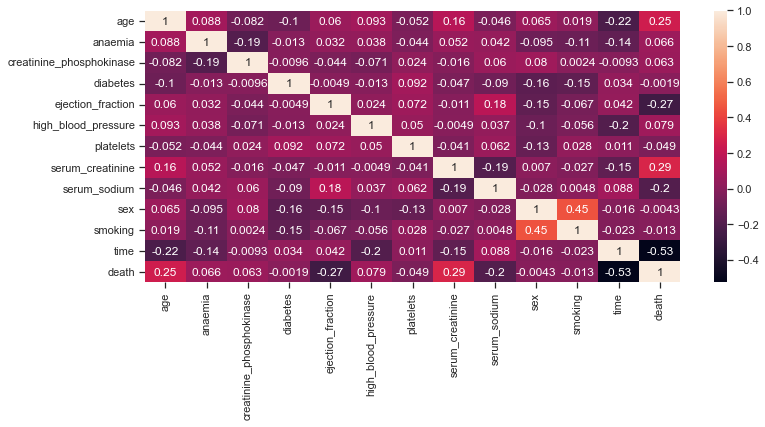

In [231]:
cor = data.corr()
plt.figure(figsize=(12,5))
sns.heatmap(cor, annot=True)

Berdasarkan nilai korelasi tersebut terdapat beberapa feature yang mempunyai korelasi tinggi dibanding yang lain, yaitu:
- time: -0.53
- serum_creatinine: 0.29
- ejection_fraction: -0.27
- age: 0.27

Korelasi positif terhadap target status kematian, menandakan apabila value tersebut meningkat, maka meningkat pula  kemungkinan meninggal atau sebaliknya. Feature seperti serum_creatine dan umur (age) terlihat masuk akal dengan korelasi positif. Sebagai contohnya semakin tua umur pasien, kemungkinan meninggalnya semakin besar.

Sedangkan korelasi negatif menandakan berkebalikan dengan target status kematian, semakin besar value features tersebut, kemungkinan meninggal semakin kecil. Beberapa feature time dan ejection fraction terlihat masuk akal dengan korelasi negatif terhadap status kematian pasien.

Feature sisanya memiliki korelasi dibawah 0.1 terhadap target death. Selain itu antar features memiliki korelasi yang rendah, kecuali pada feature sex dan smoking. Sebagaimana sudah kita amati sebellumnya bahwa memang terlihat jelas proporsi smoking male jauh lebih besar daripada female (multikolinearitas). Karena kita akan menggunakan model klasifikasi Random Forest dan algoritma bossting yang tidak terpengaruh oleh multikolinearitas feature, maka **semua features tersebut akan tetap kita sertakan dalam analisis prediksi.**

# 5 - Data Preprocessing

## Get Data for Model Inference

In [232]:
# Get Data for Model Inference

data_inf = data.sample(10, random_state=17)
data_inf

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death
121,73.0,0,582,0,20,0,263358.03,1.83,134,1,0,198,1
94,65.0,1,113,1,60,1,203000.00,0.90,140,0,0,94,0
138,50.0,0,250,0,25,0,262000.00,1.00,136,1,1,120,0
288,63.0,0,193,0,60,1,295000.00,1.30,145,1,1,107,0
139,59.0,1,176,1,25,0,221000.00,1.00,136,1,1,150,1
13,72.0,0,211,0,25,0,274000.00,1.20,134,0,0,207,0
230,90.0,1,47,0,40,1,204000.00,2.10,132,1,1,8,1
165,65.0,0,582,1,30,0,249000.00,1.30,136,1,1,212,0
58,50.0,0,318,0,40,1,216000.00,2.30,131,0,0,60,1
122,55.0,0,1199,0,20,0,263358.03,1.83,134,1,1,241,1


Berikutnya kita akan remove titik point data inference dari dataset df yang akan menjadi data untuk train dan test.

In [233]:
# Remove Inference-Set from Dataset

data_train_test = data.drop(data_inf.index)
data_train_test

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death
0,42.0,1,250,1,15,0,213000.00,1.3,136,0,0,65,1
1,46.0,0,168,1,17,1,271000.00,2.1,124,0,0,100,1
2,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
3,53.0,1,91,0,20,1,418000.00,1.4,139,0,0,43,1
4,50.0,1,582,1,20,1,279000.00,1.0,134,0,0,186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,63.0,1,122,1,60,0,267000.00,1.2,145,1,0,147,0
295,45.0,0,308,1,60,1,377000.00,1.0,136,1,0,186,0
296,70.0,0,97,0,60,1,220000.00,0.9,138,1,0,186,0
297,53.0,1,446,0,60,1,263358.03,1.0,139,1,0,215,0


Kita akan reset index untuk data_train_test, dan data_inf.

In [234]:
# Reset Index 

data_train_test.reset_index(drop=True, inplace=True) 
data_inf.reset_index(drop=True, inplace=True)

## Splitting between `X` (Features) and `y` (Target)

Disini kita akan memisahkan data antara features **X** dengan target output **y**.

In [235]:
# Split between `X` (Features) and `y` (Target)

X = data_train_test.drop('death', axis=1) 
y = data_train_test['death']

## Split between Train-Set and Test-Set

Kita akan split data menjadi data train dan data test, dengan porsi 20% untuk data test dan 80% untuk data train.

In [236]:
# Split between Train-Set and Test-Set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=17)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (231, 12)
Test Size  :  (58, 12)


## Feature scaling, encoding and Handling Outliers

Karena kita akan menggunakan ensemble teknik model yaitu Random Forest dan XGBoost dimana algoritma model tersebut tidak membutuhkan proses scaling dan handling outliers. Maka pada prses data preprocessing ini kita tidak akan melakukan feature scaling. Namun terdapat berbagai referensi yang mengatakan XGBoost sensitive terhadap outliers dan ada juga yang menyatakan sebaliknya.

Pada categorical features merupakan boolean value (1 dan 0), sehingga dirasa tidak perlu melakukan encoding seperti OneHotEncoder.

Berdasarkan berbagai pertimbangan, disini kita hanya akan handle outliers saja.

Reference:
- https://medium.com/codex/feature-scaling-in-machine-learning-e86b360d1c31

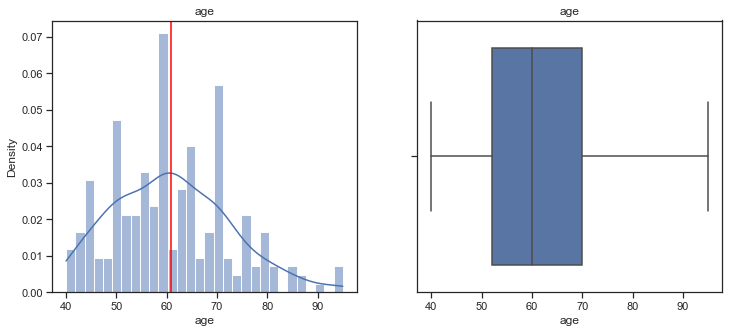

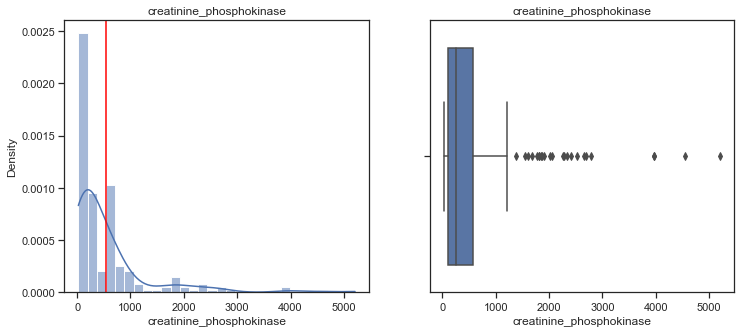

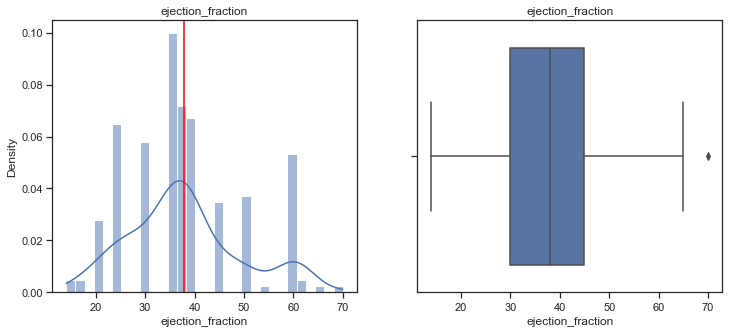

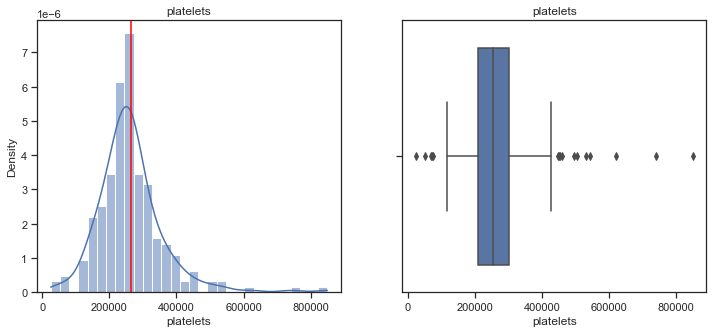

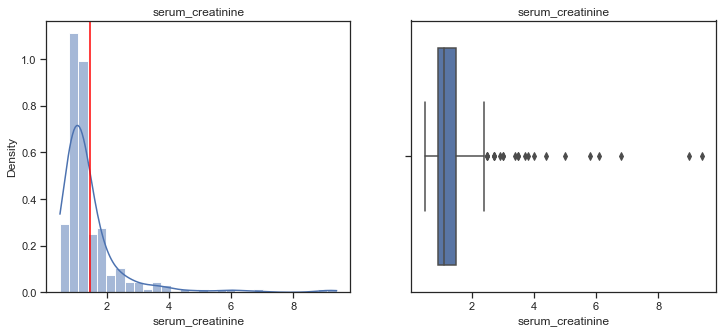

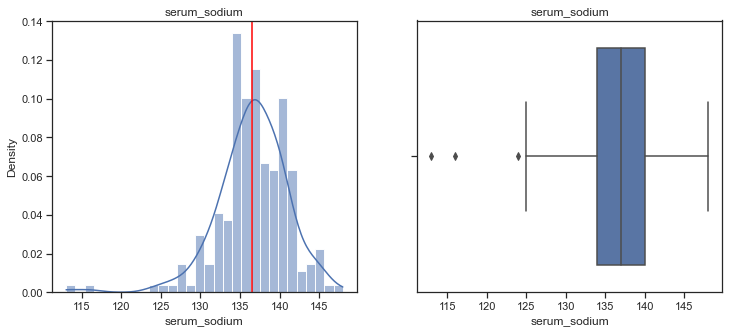

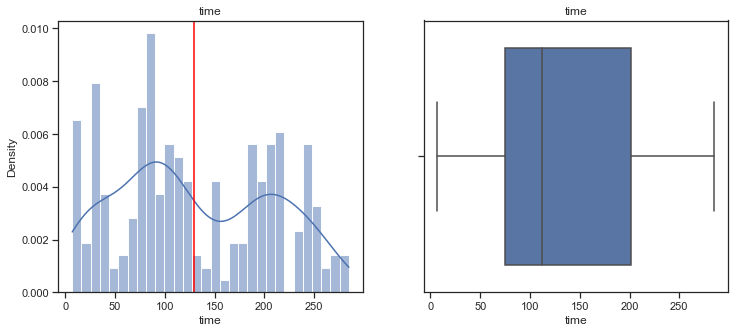

In [237]:
for col in num_cols:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(x = col,data=X_train,bins=30 ,stat='density',kde=True)
    plt.axvline(X_train[col].mean(), color = 'red')
    plt.title(col)

    plt.subplot(1,2,2)
    sns.boxplot(x = col,data=X_train)
    plt.title(col)
    plt.show()

In [238]:
def find_outliers(data,variable, distance):
    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)
    upper_bound = data[variable].quantile(0.75) + distance*IQR
    lower_bound = data[variable].quantile(0.25) - distance*IQR
    upper_rate = round(np.sum(data[variable] >= upper_bound)/len(data),2)
    lower_rate = round(np.sum(data[variable] <= lower_bound)/len(data),2)
    return upper_bound, upper_rate, lower_bound, lower_rate

In [239]:
for i in num_cols:
    print(f'''{i}: upper bound {find_outliers(X_train,i,1.5)[0]} with rate {find_outliers(X_train,i,1.5)[1]}, 
    lower bound {find_outliers(X_train,i,1.5)[2]} with rate {find_outliers(X_train,i,1.5)[3]}''')

age: upper bound 97.0 with rate 0.0, 
    lower bound 25.0 with rate 0.0
creatinine_phosphokinase: upper bound 1286.25 with rate 0.1, 
    lower bound -591.75 with rate 0.0
ejection_fraction: upper bound 67.5 with rate 0.0, 
    lower bound 7.5 with rate 0.0
platelets: upper bound 437750.0 with rate 0.05, 
    lower bound 75750.0 with rate 0.02
serum_creatinine: upper bound 2.4 with rate 0.1, 
    lower bound 1.1102230246251565e-16 with rate 0.0
serum_sodium: upper bound 149.0 with rate 0.0, 
    lower bound 125.0 with rate 0.02
time: upper bound 390.75 with rate 0.0, 
    lower bound -115.25 with rate 0.0


In [240]:
total_outliers = [False for i in range(len(X_train))]
for feature in num_cols:
    outlier = ((X_train[feature] > find_outliers(X_train,feature,1.5)[0]) | (X_train[feature] < find_outliers(X_train,feature,1.5)[2]))
    total_outliers = total_outliers | outlier

In [241]:
X_train_ready = X_train[~total_outliers]
y_train_ready = y_train[~total_outliers]

In [242]:
print('Jumlah outliers yang diremove:',len(X_train) - len(X_train_ready))
print('Jumlah data train setelah dihilangkan outliers:',len(X_train_ready))

Jumlah outliers yang diremove: 59
Jumlah data train setelah dihilangkan outliers: 172


Terdapat 59 data points yang kita remove dikarenakan data tersebut adalah outliers.

## Handling Imbalanced Data

Selanjutnya kita akan melakukan oversampling dan juga undersampling menggunakan SMOTENC (karena terdapat categorical feature) dan RandomUnderSampler untuk membuat data menjadi balance. Adapun kita menggunakan oversampling SMOTENC ini setelah handling outliers, karena algoritma oversampling tersebut mencari nearest neighbor dan memilih random points yang dimana data point sintetic tersebut berada diantara suatu point dan random point neighbor tersebut. adanya outliers memungkinkan terpilihnya random pint disana sehingga data sintetic yang dihasilkan akan tidak relevan terhadap distribusinya.

In [243]:
over = SMOTENC(categorical_features=[1,3,5,9,10],sampling_strategy=0.8, random_state= 27)
under = RandomUnderSampler(sampling_strategy=0.9, random_state=27)
X_train_balance,y_train_balance = over.fit_resample(X_train_ready,y_train_ready)
X_train_balance2,y_train_balance2 = under.fit_resample(X_train_balance,y_train_balance)

In [244]:
y_train_ready.value_counts()

0    125
1     47
Name: death, dtype: int64

In [245]:
y_train_balance.value_counts()

0    125
1    100
Name: death, dtype: int64

In [246]:
y_train_balance2.value_counts()

0    111
1    100
Name: death, dtype: int64

# 6 - Model Definition

Algoritma yang dipakai adalah `Random Forest` dan `XGBClassifier` untuk memprediksi target output class death. Karena kedua model tersebut cocok untuk klasifikasi, tidak begitu berdampak scaling numeric features dan tidak memakan waktu yang lama pada komputasinya.

- Random Forest: Parameter yang digunakan adalah min_sample_split untuk mengurangi overfit, class_weight karena data tergolong imbalanced data.
- XGBClassifier: Parameter yang digunakan adalah min_child_weight, scale_pos_weight, dan max_depth.

Metrics yang digunakan untuk evaluasi model adalah roc auc score, recall dan f1 score. Mengingat data sebenarnya tergolong imbalanced, dan prioritas adalah meminimalisir false negative kelas 1 atau meningkatkan recall. Sebagaimana recall adalah perbandingan jumlah prediksi kelas positive terhadap jumlah aktual positive. Sedangkan roc auc score menunjukkan luas daerah kurva roc, yang secara tidak langsung menunjukkan comparison antara recall dan false positive rate.

# 7 - Model Training

Pada proses ini kita akan melakukan beberapa percobaan pada masing-masing model untuk menentukan value parameter yang dirasa tepat.

## Random Forest Model

### Set hyperparameter

Pertama kita akan set parameter class_weight dan mencari nilai roc auc score yang terbaik.

In [247]:
param_rf = {'class_weight':["balanced_subsample",'balanced']} #Parameter for Random Forest

In [248]:
# Mencari value class_weight dengan f1 score terbaik
grid_rf = GridSearchCV(RandomForestClassifier(),param_grid = param_rf, scoring = 'recall')
grid_rf.fit(X_train_balance2,y_train_balance2)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced_subsample', 'balanced']},
             scoring='recall')

Lalu didapat class_weight terbaik sebagai berikut.

In [249]:
grid_rf.best_params_

{'class_weight': 'balanced'}

Dikarenakan tree model (termasuk Random Forest) memiliki kecenderungan over-fit, maka kita akan melakukan pruning dengan min_samples_split terbaik dimana tidak terdapat perbedaan yang jauh antara f1score test dan train.

In [250]:
# Fucntion yang menghasilkan f1 score train dan test berdasarkan model
def modelfit(alg, X, y,X1,y1,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    train_predictions = alg.predict(X)
    test_predictions = alg.predict(X1)
    train_pred = alg.predict(X)
    test_pred = alg.predict(X1)

    return f1_score(y, train_pred), f1_score(y1, test_pred)

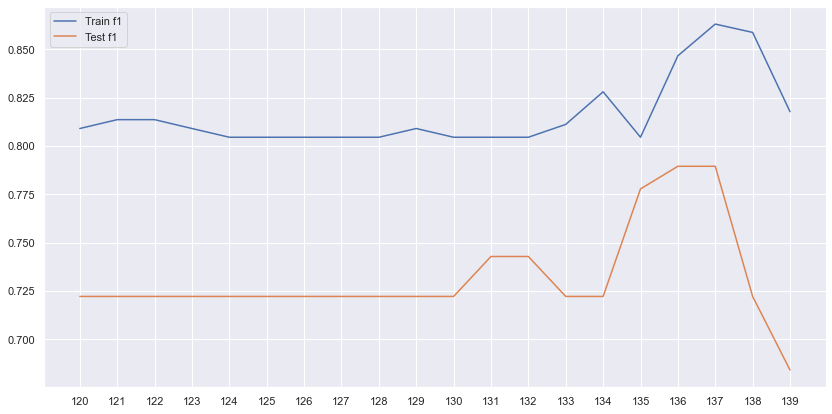

In [251]:
# Plot f1 score train dan test
f1_train = []
f1_test = []
msl = range(120,140)
for i in msl:
    tree=RandomForestClassifier(class_weight=grid_rf.best_params_['class_weight'],min_samples_split=i,random_state=27)
    f1_train_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[0]
    f1_test_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[1]
    f1_train.append(f1_train_score)
    f1_test.append(f1_test_score)
   
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_train,x=msl,label="Train f1")
sns.lineplot(y=f1_test,x=msl,label="Test f1")
plt.xticks(msl)
plt.show()

Dari grafik tersebut dapat kita perhatikan jarak terkecil nilai f1 score test dan train pada min_samples_split 135.

### Define model, fit and predict

Berdasarkan percobaan sebelumnya, kita telah menentukan model Random Forest dengan parameter:
- min_samples_split = 135
- class_weight: Yang didapatkan berdasarkan gridsearch

In [252]:
model_rf = RandomForestClassifier(class_weight=grid_rf.best_params_['class_weight'],min_samples_split=135,random_state=27)
model_rf.fit(X_train_balance2,y_train_balance2)

RandomForestClassifier(class_weight='balanced', min_samples_split=135,
                       random_state=27)

Sehingga kita bisa menghasilkan hasil prediksi sebagai berikut.

In [253]:
y_pred_train_rf = model_rf.predict(X_train_balance2)
y_pred_test_rf = model_rf.predict(X_test)

## XGBClassifier

### Set hyperparameter

Terdapat banyak sekali hyperparameter pada XGBClassifier yang dapat kita tentukan. Disini hyperparameter yang akan kita tentukan adalah gamma dan min_child_weight. Pencarian value hyperparameter disini akan dicari manual satu per satu dengan membandingkan dengan f1 score data train dan data test.

Pertama kita akan coba mencari value min_child_weight yang sesuai.

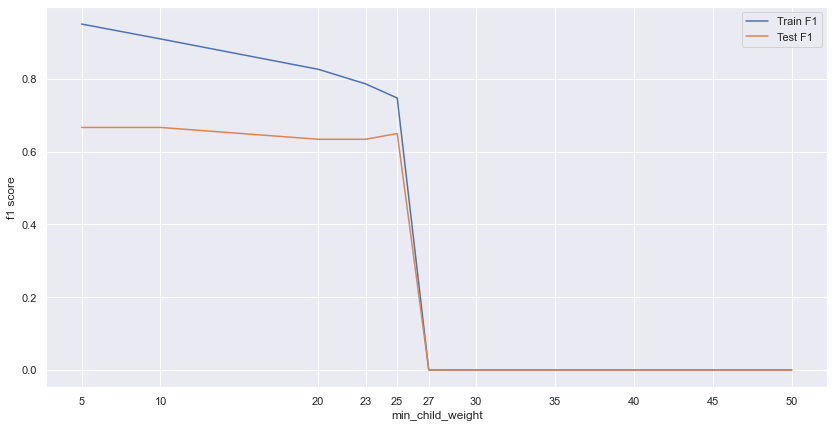

In [254]:
# Plot f1 score train dan test berdasarkan min_child_weight
f1_xgb_train = []
f1_xgb_test = []
n = [5,10,20,23,25,27,30,35,40,45,50]
for i in n:
    tree=XGBClassifier(min_child_weight=i)
    f1_train_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[0]
    f1_test_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[1]
    f1_xgb_train.append(f1_train_score)
    f1_xgb_test.append(f1_test_score)
   
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_xgb_train,x=n,label="Train F1")
sns.lineplot(y=f1_xgb_test,x=n,label="Test F1")
plt.xticks(n)
plt.xlabel('min_child_weight')
plt.ylabel('f1 score')
plt.show()

Didapat value min_child_weight sebesar 25 membuat f1 score test dan train mempunyai minimum selisih, namun mengalami penurunan pada f1 score train. Maka untuk berjaga-jaga kita akan ambil value sesaat sebelum 25, misalkan 20.

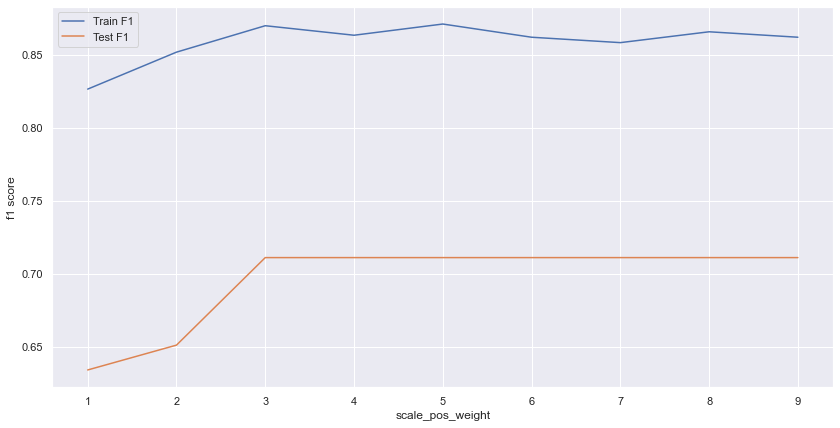

In [255]:
# Plot f1 score train dan test berdasarkan scale_pos_weight
f1_xgb_train = []
f1_xgb_test = []
n = range(1,10)
for i in n:
    tree=XGBClassifier(min_child_weight=20,scale_pos_weight=i)
    f1_train_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[0]
    f1_test_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[1]
    f1_xgb_train.append(f1_train_score)
    f1_xgb_test.append(f1_test_score)
   
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_xgb_train,x=n,label="Train F1")
sns.lineplot(y=f1_xgb_test,x=n,label="Test F1")
plt.xticks(n)
plt.xlabel('scale_pos_weight')
plt.ylabel('f1 score')
plt.show()

F1score cenderung konstan pada data test untuk scale_pos_weight di atas 3. Kita akan memilih scale_pos_weight 5.

Selanjutnya kita akan mencari max_depth.

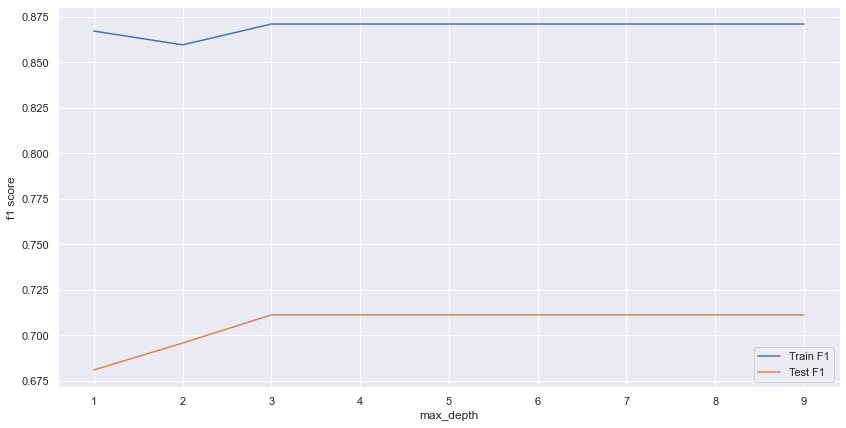

In [256]:
# Plot f1 score train dan test berdasarkan max_depth
f1_xgb_train = []
f1_xgb_test = []
n = range(1,10)
for i in n:
    tree=XGBClassifier(min_child_weight=20,scale_pos_weight=5,max_depth = i)
    f1_train_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[0]
    f1_test_score = modelfit(tree,X_train_balance2,y_train_balance2,X_test,y_test)[1]
    f1_xgb_train.append(f1_train_score)
    f1_xgb_test.append(f1_test_score)
   
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_xgb_train,x=n,label="Train F1")
sns.lineplot(y=f1_xgb_test,x=n,label="Test F1")
plt.xticks(n)
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.show()

Dapat untuk max_depth > 3 value f1 score konstan, baik pada data train maupun data test. Kita akan set max_depth sekitar 4 dengan value f1 score tinggi pada data test.

Sehingga value parameter yang kita set pada XGBClassifier adalah:
- min_child_weight: 20
- scale_pos_weight: 5
- max_depth: 4

In [257]:
# Definisikan dan fit model
model_xgb = XGBClassifier(min_child_weight = 20, scale_pos_weight = 5, max_depth = 4)
model_xgb.fit(X_train_balance2,y_train_balance2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=20,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Kita bisa menghasilkan prediksi dengan model XGBClassifier yang sudah kita set sebagai berikut.

In [258]:
y_pred_train_xgb = model_xgb.predict(X_train_balance2)
y_pred_test_xgb = model_xgb.predict(X_test)

# 8 - Model Evaluation

Cek classification score pada kedua model.

In [259]:
print('Train Random Forest\n',classification_report(y_train_balance2,y_pred_train_rf))
print('Test Random Forest\n',classification_report(y_test,y_pred_test_rf))

Train Random Forest
               precision    recall  f1-score   support

           0       0.79      0.94      0.86       111
           1       0.91      0.72      0.80       100

    accuracy                           0.83       211
   macro avg       0.85      0.83      0.83       211
weighted avg       0.85      0.83      0.83       211

Test Random Forest
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        40
           1       0.78      0.78      0.78        18

    accuracy                           0.86        58
   macro avg       0.84      0.84      0.84        58
weighted avg       0.86      0.86      0.86        58



In [260]:
print('Train XGB\n',classification_report(y_train_balance2,y_pred_train_xgb))
print('Test XGB\n',classification_report(y_test,y_pred_test_xgb))

Train XGB
               precision    recall  f1-score   support

           0       0.98      0.76      0.85       111
           1       0.78      0.98      0.87       100

    accuracy                           0.86       211
   macro avg       0.88      0.87      0.86       211
weighted avg       0.89      0.86      0.86       211

Test XGB
               precision    recall  f1-score   support

           0       0.94      0.72      0.82        40
           1       0.59      0.89      0.71        18

    accuracy                           0.78        58
   macro avg       0.76      0.81      0.76        58
weighted avg       0.83      0.78      0.78        58



Pada kasus kita disini, prioritas adalah **meminimalkan pasien yang meninggal namun terprediksi hidup**. Atau dengan kata lain kita ingin meminimalkan recall score pada kelas 1.

Berdasarkan hasil report di atas, terlihat pada model Random Forest memiliki kemampuan yang agak kurang dalam prediksi target kelas 1 dibanding kelas 0. Hal tersebut dikarenakan data termasuk imbalanced (meskipun kita telah set berbagai parameter model dan melakukan resample). Namun dari sini kita dapat melihat recall score pada model XGB lebih baik dibanding model Random Forest (pada data test). Namuan selain recall, score f1,precision dan accuracy hasil prediksi test model Random Forest lebih besar daripada model XGB.

Untuk lebih detailnya kita bisa menampilkan dalam confussion matrix berikut.

Text(0.5, 1.0, 'XGB')

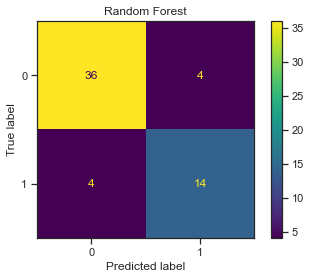

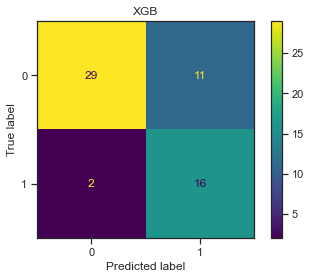

In [261]:
#Confussion matrix Random Forest data test
cm_rf = confusion_matrix(y_test,y_pred_test_rf)
cm_xgb = confusion_matrix(y_test,y_pred_test_xgb)

sns.set_style('ticks')
ConfusionMatrixDisplay(cm_rf).plot()
plt.title('Random Forest')

ConfusionMatrixDisplay(cm_xgb).plot()
plt.title('XGB')

Dapat dilihat bahwa terdapat 4 orang yang meninggal namun diprediksi hidup pada model random forest, sedangkan pada model XGB terdapat 2 orang yang meninggal namun diprediksi hidup. Tentu hal tersebut sangat berbahaya apabila suatu pasien yang sekiranya akan meninggal namun diprediksi masih hidup, karena pasien tersebut akan tidak mendapatkan treatment yang sebagaimana mestinya dan pasien tersebut menjadi kurang aware akan kondisnya karena sudah divonis tidak akan meninggal.

Apabila kita perhatikan jumlah true negative (kelas 0) dan false positive pada model Random Forest lebih baik dibanding model XGB.

Secara keseluruhan model Random lebih baik daripada model XGB (berdasarkan value parameter yang kita lakukan disini), meskipun XGB memiliki false negative yang lebih baik daripada Random forest, namuan perbedaannya tidak jauh. Sementara di berbagai hal seperti false positive, precisions, accuracy model Random Forest lebih baik secara keseluruhan.

Kita juga dapat menampilkan ROC curve data test pada kedua model, beserta nilai area under roc curve.

In [262]:
#Probability for data test
proba_rf = model_rf.predict_proba(X_test)
proba_xgb = model_xgb.predict_proba(X_test)

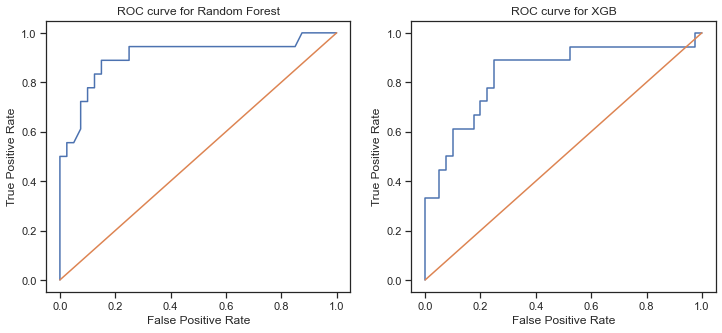

Random forest roc auc: 0.9041666666666667
XGB roc auc: 0.8347222222222223


In [263]:
# ROC curve pada model logistic regression tanpa tuning
fpr, tpr, thresholds = roc_curve(y_test, proba_rf[:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, proba_xgb[:,1])
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve for Random Forest")

plt.subplot(1,2,2)
plt.plot(fpr1,tpr1)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve for XGB")
plt.show()


print("Random forest roc auc:",roc_auc_score(y_test,proba_rf[:,1]))
print("XGB roc auc:",roc_auc_score(y_test,proba_xgb[:,1]))

Terlihat roc auc score random forest sebesar 0.904 lebih besar dibanding roc auc score XGB yaitu sebesar 0.84. Hal ini nampak sesuai dengan overall score random forest lebih baik daripada XGB (kecuali recall).

# 9 - Model Inference

Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set, yakni data inference. 

In [264]:
X_inf = data_inf.drop('death', axis = 1)
y_inf = data_inf['death']

In [265]:
# Hasil prediksi data inference dari kedua model Random Forest dan XGBClassifier
y_pred_inf_rf = model_rf.predict(X_inf)
y_pred_inf_xgb = model_xgb.predict(X_inf)

Karena hanya sedikit jumlah data inference, kita bisa langsung menampilkan value target aktual beserta hasil prediksi kedua model dalam dataframe sebagai berikut.

In [266]:
inf_prediction = pd.DataFrame({'death':y_inf,'predict_rf':y_pred_inf_rf,'predict_xgb':y_pred_inf_xgb})
inf_prediction

,death,predict_rf,predict_xgb
0,1,1,1
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,0
5,0,0,1
6,1,1,1
7,0,0,1
8,1,1,1
9,1,1,1


Dapat dilihat kedua model dapat memprediksi dengan lancar. Pada dari 10 data inference, terdapat satu kali miss prediksi (pada aktual target death = 1) pada prediksi model Random Forest, sedangkan pada model xgb terdapat tiga kali salah (pada aktual target death = 1).

# 10 - Kesimpulan

Prediksi status kematian (death) pada data ini dilakukan dengan model Random Forest dan XGBClassifier.
Sebelum dilakukan prediksi dengan dua model tersebut, terdapat beberapa masalah:
- Jumlah data yang sedikit
- Imbalanced data (Jumlah banyaknya value target 0 lebih besar daripada banyaknya value target 1)
- Terdapat banyak outliers. Merupakan suatu keputusan yang sulit apabila dilakukan remove ataupun impute.

Treatment yang dilakukan terhadap masalah tersebut adalah menghilangkan outliers dan melakukan over dan under sampling untuk menyeimbangkan jumlah value target. Pada analisis ini tidak dilakukan feature scaling maupun encoding, dikarenakan algoritma random forest maupun XGb tidak dipengaruhi oleh scale dan categorical features disini sudah merupakan binary value atau boolean (1 dan 0). Lalu setelahnya dilakukan oversampling dan undersampling untuk membuat data menjadi balance.

Sebelum menghasilkan suatu prediksi dari kedua model, dilakukan tuning hyperparameter terhadap kedua model. Pada kasus kita disini, prioritas adalah **meminimalkan pasien yang meninggal namun terprediksi hidup**. Atau dengan kata lain kita ingin meminimalkan recall score pada kelas 1.

Berdasarkan hasil evaluasi, terlihat pada model Random Forest memiliki kemampuan yang agak kurang dalam prediksi target kelas 1 dibanding kelas 0. Hal tersebut dikarenakan data termasuk imbalanced (meskipun kita telah set berbagai parameter model dan melakukan resample). Namun dari sini kita dapat melihat recall score pada model Random Forest lebih baik dibanding model XGB (pada data test). Selain recall, score f1,precision dan accuracy hasil prediksi test model Random Forest lebih besar daripada model XGB. Dapat dilihat bahwa terdapat 4 orang yang meninggal namun diprediksi hidup pada model random forest, sedangkan pada model XGB terdapat 5 orang yang meninggal namun diprediksi hidup. Apabila kita perhatikan jumlah true negative (kelas 0) dan false positive pada model Random Forest lebih baik dibanding model XGB. Dengan demikian berdasarkan hasil tersebut nampak model Random Forest lebih baik daripada XGB (berdasarkan tuning yang telah dilakukan). Mengingat data set yang dimiliki tidak berjumlah banyak, sehingga data yang digunakan untuk test pun juga tidak banyak, hanya 58. Sehingga hasil score evaluasi dari dua model tersebut bisa saja kurang akurat. Selain itu faktor oversampling disini bisa saja mengakibatkan pembelajaran model terhadap kelas positive kurang maksimal.

Overall performa prediksi model Random forest disini jauh lebih baik dibanding model XGB. Bisa saja model XGB tersebut dapat ditingkatkan performance nya dengan tuning hyperparameter yang tepat. Namun karena terdapat banyak sekali parameter dari model XGB, akan memakan waktu dan komputasi yang lama untuk bereksperimen dalam pencarian value parameternya.

# QUESTIONS

## 1. Apakah yang dimaksud dengan Bagging?

Bagging atau Bootstrap Aggregation merupakan ensemble teknik yang digunakan random forests. Pada prosesnya bagging mengambil sample dari data set (untuk estimasi populasi dataset) yang berbeda untuk tiap sejumlah model classifier yang disebut *bootstrap*. Dari tiap model tersebut akan bekerja secara parallel dan independent menghasilkan suatu prediksi. Dari kesemua hasil prediksi tersebut akan dilakukan *aggregation*, misal pada classification task akan diambil mayoritas hasil prediksi dari semua model tersebut pada suatu input.

Keuntungan melakkukang Bagging adalah mengurangi kecenderungan overfit, improve accuracy dan efisien pada data dengan feature yang banyak atau high dimensional data. Namuan Bagging akan semakin melambat komputasinya bila jumlah iterasinya semakin banyak.

## 2. Jelaskan perbedaan algoritma Random Forest dengan algoritma boosting yang Anda pilih?

Random forest termasuk Bagging ensemble dimana diambil sample yang berbeda untuk tiap tree, tiap tree bekerja secara independent dan parallel sehingga akhirnya mengeluarkan output berdasarkan mean, median atau mode (bergantung pada regression atau classification) dari tiap output tree. 

Sedangkan XGBoost merupakan boosting ensemble dimana katakanlah terdapat $n$ model yang diberikan sample pada tiap model (*weak learner*) yang bekerja tidak secara parallel namuan secara berurutan. Model $k=1$ bekerja dengan sample yang diterima lalu menghasilkan suatu output, apabila terdapat error maka datapoints error tersebut akan diberikan weight yang lebih untuk model selanjutnya $k=2$. Apabila model $k=2$ masih mendapatkan error yang sama dari data points sebelumnya maka data points tersebut akan diberikan weight lebih ke model selanjutnya (beserta error lain yang didapat dari sample model $k=2$). Proses tersebut terus berlanjut hingga model $k=n$ dan mengeluarkan output dari hasil pembelajaran model-model sebelumnya.

Gradient boosting disini merupakan proses meminimumkan loss function suatu model menggunakan gradient descent. Kontribusi tiap weak learner hingga ke final prediksi merupakan berdasarkan gradient optimisasi proses untuk meminimalkann error strong learner.

XGBosst dapat langsung melakukan pruning dengan *similarity score*, sedangkan Random forest bisa saja terjadi *overfit* apabila kebanyakan trees diberikan sample yang saling serupa. Namun di satu sisi, Random Forest lebih mudah dilakukan tuning hyperparameter dibanding XGBoost yang memiliki banyak parameter. 